In [41]:
import pandas as pd
import lightgbm as lgb
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [34]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")
weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]
df = df[["forecast_dt", "rt_plant_id", "production", *weather_cols]]

In [35]:
TRAIN_END = pd.Timestamp("2022-01-01")
VALID_START = TRAIN_END
VALID_END = VALID_START + pd.Timedelta(days=1)
TEST_START = VALID_END
TEST_END = TEST_START + pd.Timedelta(days=1)

In [36]:
df = df.sort_values(["rt_plant_id", "forecast_dt"])
train_indexes = df[df.forecast_dt < TRAIN_END].index
valid_indexes = df[(df.forecast_dt >= VALID_START) & (df.forecast_dt < VALID_END)].index
test_indexes = df[(df.forecast_dt >= TEST_START) & (df.forecast_dt < TEST_END)].index

In [37]:
y_test = df.loc[test_indexes, "production"].copy()
df.loc[test_indexes, "production"] = np.nan

In [38]:
train_df = df.loc[train_indexes]
valid_df = df.loc[valid_indexes]
test_df = df.loc[test_indexes]

In [40]:
train_df = train_df.dropna()
y_train = train_df["production"]
X_train = train_df.drop(columns=["forecast_dt", "production"])

y_valid = valid_df["production"]
X_valid = valid_df.drop(columns=["forecast_dt", "production"])

# y_test = test_df["production"]
X_test = test_df.drop(columns=["forecast_dt", "production"])

# for col in ["rt_plant_id", "hour", "dayofweek"]:
for col in ["rt_plant_id"]:
    X_train[col] = X_train[col].astype("category")
    X_valid[col] = X_valid[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [42]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    "num_boost_round": 1000,
    'metric': {'l2', 'l1'},
    # 'num_leaves': 51,
    # 'learning_rate': 0.03,
    # 'feature_fraction': 0.9,
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'verbose': 1,
    "categorical_feature": ["rt_plant_id", "hour", "dayofweek"]
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
                )


Starting training...
[LightGBM] [Warning] categorical_feature is set=rt_plant_id,hour,dayofweek, categorical_column=0 will be ignored. Current value: categorical_feature=rt_plant_id,hour,dayofweek
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2135
[LightGBM] [Info] Number of data points in the train set: 2420406, number of used features: 9
[LightGBM] [Info] Start training from score 14.788416
[1]	valid_0's l2: 152.493	valid_0's l1: 11.6259
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 135.53	valid_0's l1: 10.9249
[3]	valid_0's l2: 120.117	valid_0's l1: 10.2431
[4]	valid_0's l2: 106.811	valid_0's l1: 9.60812
[5]	valid_0's l2: 96.6251	valid_0's l1: 9.09395
[6]	valid_0's l2: 86.462	valid_0's l1: 8.5545
[7]	valid_0's l2: 78.9876	valid_0's l1: 8.1310

In [43]:
# print('Saving model...')
# save model to file
# gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
from sklearn.metrics import mean_squared_error
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

Starting predicting...
The RMSE of prediction is: 11.091525914932145


In [44]:
feature_importances = gbm.feature_importance()
feature_names = gbm.feature_name()
pd.DataFrame([feature_importances, feature_names]).T.sort_values(0, ascending=False).head(20)

,0,1
0,1315,rt_plant_id
8,355,VGRD_80.m.above.ground.SE
5,346,VGRD_80.m.above.ground.SW
6,327,VGRD_80.m.above.ground.NW
7,259,VGRD_80.m.above.ground.NE
3,257,UGRD_80.m.above.ground.NE
1,209,UGRD_80.m.above.ground.SW
2,199,UGRD_80.m.above.ground.NW
4,183,UGRD_80.m.above.ground.SE


In [45]:
test_df["prediction"] = y_pred
test_df["production"] = y_test
y_valid = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
valid_df["prediction"] = y_valid


<AxesSubplot:xlabel='hour'>

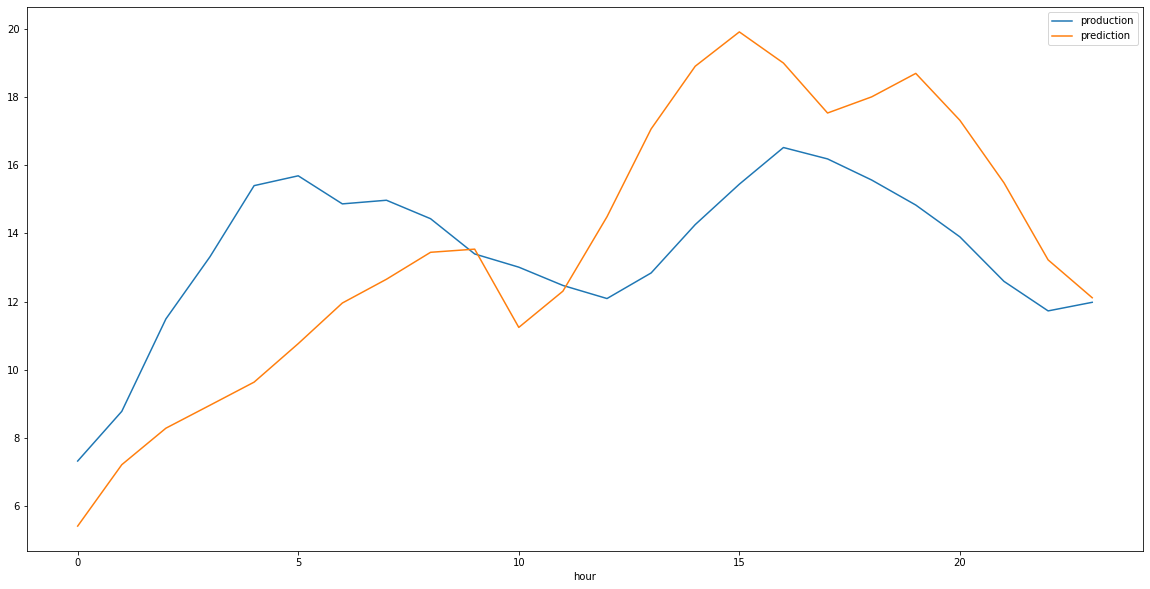

In [46]:
test_df["hour"] = test_df["forecast_dt"].dt.hour
test_df.groupby("hour")[["production", "prediction"]].mean().plot(figsize=(20,10))

<AxesSubplot:xlabel='hour'>

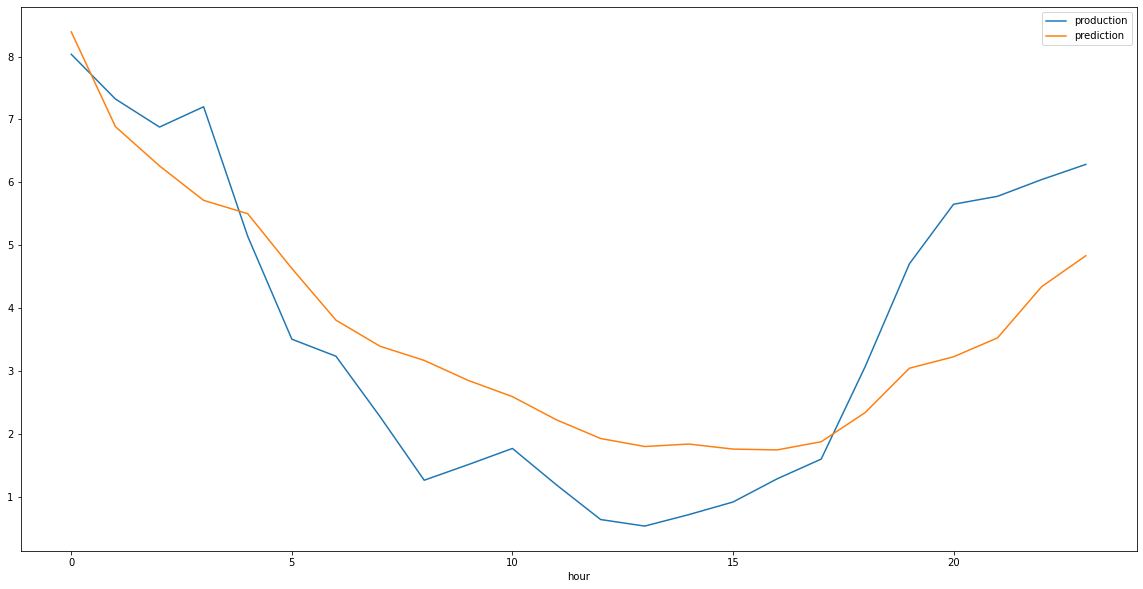

In [47]:
valid_df["hour"] = valid_df["forecast_dt"].dt.hour
valid_df.groupby("hour")[["production", "prediction"]].mean().plot(figsize=(20,10))

In [52]:
PLANT_ID = 968

<AxesSubplot:xlabel='forecast_dt'>

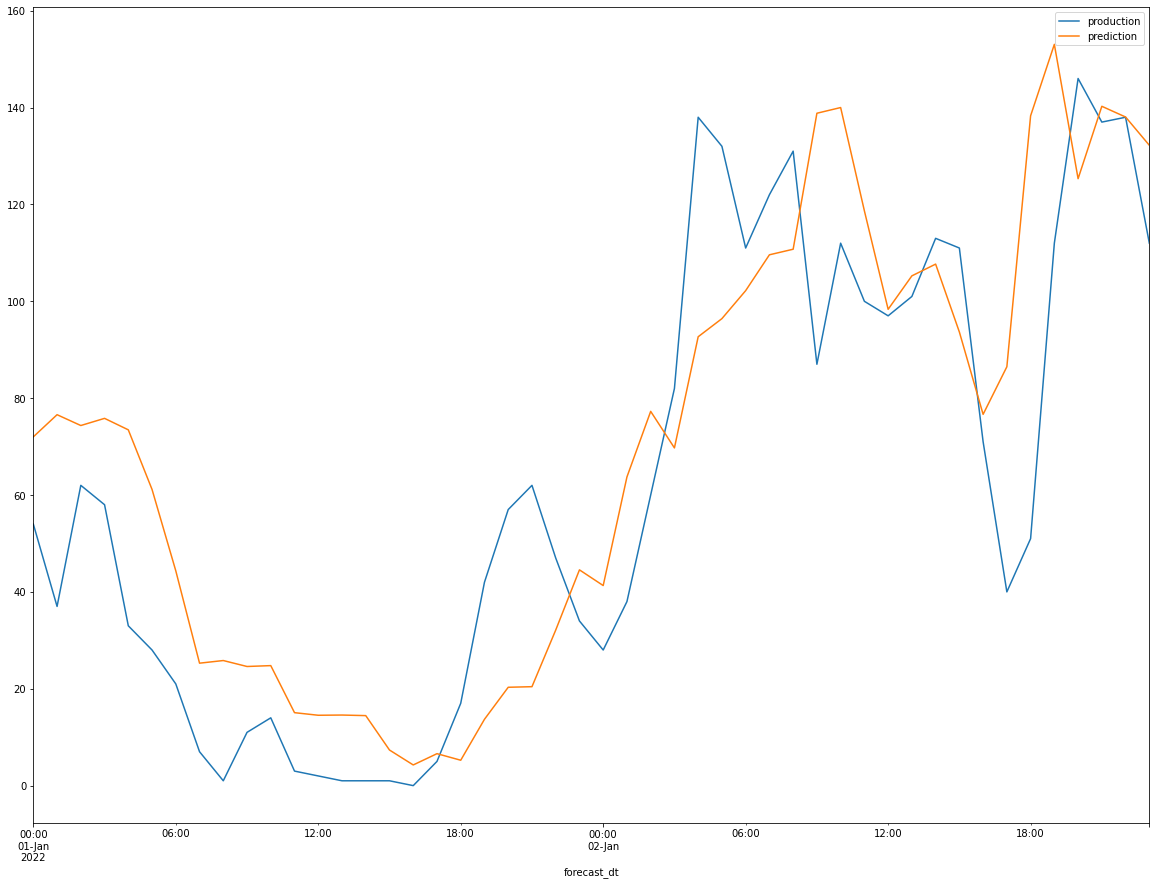

In [53]:
out_ = pd.concat([valid_df[(valid_df["rt_plant_id"] == PLANT_ID)], test_df[(test_df["rt_plant_id"] == PLANT_ID)]])
out_.set_index("forecast_dt", inplace=True)
out_[["production", "prediction"]].plot(figsize=(20,15))

<AxesSubplot:xlabel='forecast_dt'>

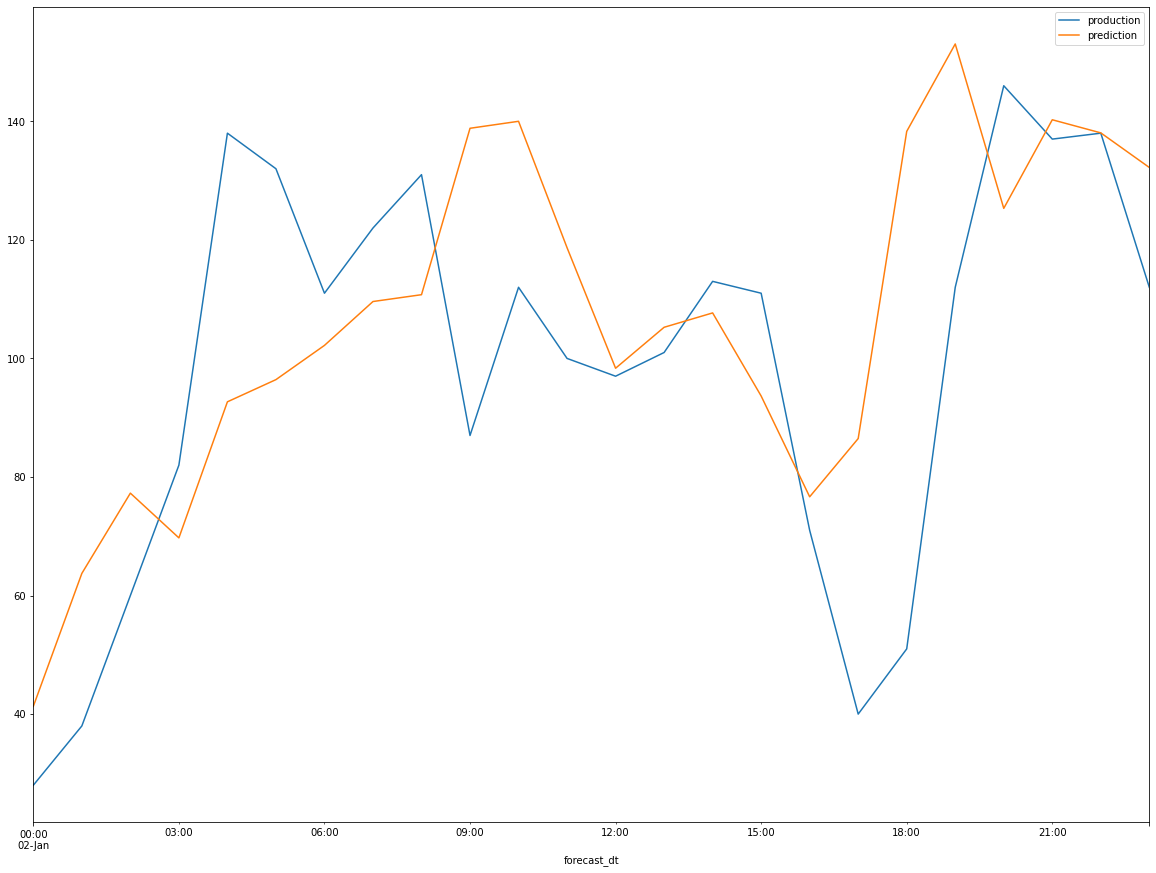

In [54]:
out_ = test_df[(test_df["rt_plant_id"] == PLANT_ID)]
out_.set_index("forecast_dt", inplace=True)
out_[["production", "prediction"]].plot(figsize=(20,15))

In [55]:
out_[["production", "prediction"]].sum()

production    2370.000000
prediction    2556.473373
dtype: float64